In [1]:
from keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D

from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
import numpy as np
import os
from tensorflow.keras.utils import img_to_array, load_img


In [ ]:
#this basically takes one leaf image from every file in the dataset and prints the name of the leaf with the image. it gets the name from the folder name.
image_paths=[]
names=[]
root="leafimages/train/"
for folder in os.listdir(root):
    fi=os.listdir(root+folder)[0]
    image_paths.append(root+"/"+folder+"/"+fi)
    c=0
    w=""
    for a in folder[::-1]:
       if a==" ":
           c=1
       if c==1:
            w+=a
    names.append(w[::-1])

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
axes = axes.flatten()
for i, image_path in enumerate(image_paths):
    img=load_img(image_path, target_size=(256,256))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].text(0.5, -0.1, names[i], size=10, ha="center", transform=axes[i].transAxes)


plt.tight_layout()

# Show the plot
plt.show()

In [3]:
classes=len(os.listdir("leafimages/train"))
inputs_2 = Input(shape=(256, 256, 3), name="img")

In [4]:
vgg = VGG16(input_tensor=inputs_2, weights='imagenet', include_top=False) 
for layer in vgg.layers:
    layer.trainable = False

In [5]:

resnet = ResNet50(input_tensor=inputs_2, weights='imagenet', include_top=False)       
for layer in resnet.layers:
    layer.trainable = False


In [6]:
mergedOutput = Concatenate()([vgg.output, resnet.output])
mergedOutput = GlobalAveragePooling2D()(mergedOutput)  
x = layers.Dense(256, activation="relu")(mergedOutput)
prediction = Dense(classes, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [7]:


# Custom preprocessing function for the hybrid model
def hybrid_preprocess_input(img):
    vgg16_preprocessed_img = vgg16_preprocess_input(img[:, :, :3])
    resnet50_preprocessed_img = resnet50_preprocess_input(img[:, :, 3:])
    hybrid_preprocessed_img = np.concatenate([vgg16_preprocessed_img, resnet50_preprocessed_img], axis=-1)
    return hybrid_preprocessed_img

# Custom data generator with hybrid preprocessing
class HybridDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super(HybridDataGenerator, self).__init__(*args, **kwargs)

    def preprocess_input(self, x):
        return hybrid_preprocess_input(x)

# Example usage of the custom data generator
datagen = HybridDataGenerator(shear_range=0.3,horizontal_flip=True)  # You can customize other parameters

train_generator = datagen.flow_from_directory(
    'leafimages/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    
)

validation_generator = datagen.flow_from_directory(
    'leafimages/val',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    
)


Found 3397 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


In [ ]:
t_img, label=train_generator.next()
import matplotlib.pyplot as plt
def plotimg(imgarr,label):
    for im, l in zip(imgarr,label):
        plt.figure(figsize=(5,5))
        plt.imshow(im/255)
        plt.show()
count=3 #change this to print the number of preprocessed images
plotimg(t_img[:count],label[:count])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['img[0][0]']                    
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
NUM_EPOCHS = 5
EARLY_STOP_PATIENCE = 5

In [11]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1)
mc=ModelCheckpoint(filepath="base_model.h5",monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1,save_best_only=True)
cb=[es,mc]

In [15]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')
tf.device('/physical_device:GPU:0')

In [ ]:

his=model.fit_generator(train_generator,epochs=3,
                        steps_per_epoch=16,
                        verbose=1,
                        callbacks=cb,
                        validation_data=validation_generator,
                        validation_steps=16)

In [53]:
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

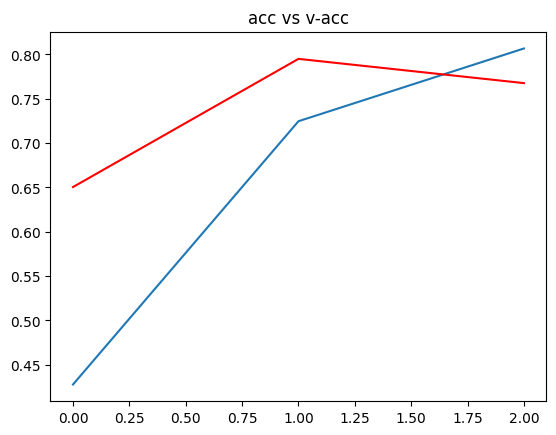

In [54]:
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"],c="red")
plt.title("acc vs v-acc")
plt.show()

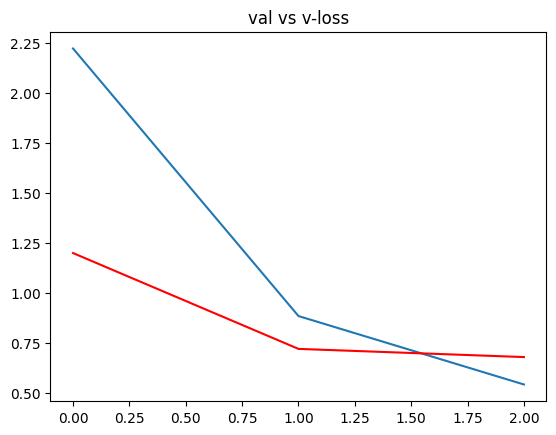

In [55]:
plt.plot(h["loss"])
plt.plot(h["val_loss"],c="red")
plt.title("val vs v-loss")
plt.show()

In [40]:
from keras.models import load_model
model=load_model("base_model.h5")

In [9]:
#this will use the generated model and find its accuracy values
acc=model.evaluate_generator(validation_generator)[1]
print("accuracy:"+str(acc))

C:\Users\Anudeep Bura\AppData\Local\Temp\ipykernel_16160\3145694370.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(validation_generator)[1]


: 

In [41]:
import torch
def drawbounding(path,dise,name):
    model = torch.hub.load('yolov5','custom', path="last_t.pt",source='local')
    results = model(path)
    results.show()
    areas=[]
    den=0
    num=0
    box=results.xyxy[0]
    for i in range(len(box)):
        area=(float(box[i][0])-float(box[i][2]))*(float(box[i][1])-float(box[i][3]))
        areas.append(areas)
        if i==0:
            den+=area
        else:
            num+=area
    print("infected area:"+str((num/den)*100)+"%")
    print("Leaf Class:"+name)
    dis={0:[0,2],
        1:[10,12,16],
        2:[4,6,8,14,18]}
    leafref={0:"bacterial",
            1:"fungus",
            2:"virus"}
    for i in dis:
        if dise in dis[i]:
            print("infected with:"+leafref[i])
            break
    print("Age:"+str(abs(int((box[0][4])*100)-20))+" days")

In [42]:
from tensorflow.keras.utils import img_to_array, load_img
ref=dict(zip(list(train_generator.class_indices.values()),list(train_generator.class_indices.keys())))
def predi(path):
    img=load_img(path, target_size=(256,256))
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    i=img_to_array(img)
    img=np.expand_dims(i,axis=0)
    pred=np.argmax(model.predict(img))
    plt.title("class: "+ref[pred])
    plt.show()
    drawbounding(path,pred,ref[pred])

In [ ]:
path="leafimages/val/Jatropha (P6)_diseased/0018_0032.JPG"
predi(path)